In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

from seiz_eeg.dataset import EEGDataset

# The data

We model *segments* of brain activity, which correspond to windows of a longer *session* of EEG recording.

These segments, and their labels, are described in the `segments.parquet` files, which can be directly loaded with `pandas`.

In [3]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "../data"

DATA_ROOT = Path(data_path)

We have train segments, with labels...

In [4]:
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")
display(clips_tr.iloc[100:115])

,label,start_time,end_time,date,sampling_rate,signals_path
id,,,,,,
pqejgcpt_s002_t001_0,0,0.0,12.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_1,0,12.0,24.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_2,0,24.0,36.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_3,0,36.0,48.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_4,0,48.0,60.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_5,0,60.0,72.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_6,0,72.0,84.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_7,0,84.0,96.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_8,0,96.0,108.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet


... and test segments, unlabeled.

In [5]:
clips_te = pd.read_parquet(DATA_ROOT / "test/segments.parquet")
display(clips_te.head(50))

,start_time,end_time,date,sampling_rate,signals_path
id,,,,,
pqejgcvm_s001_t000_0,0.0,12.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_1,12.0,24.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_2,24.0,36.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_3,36.0,48.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_4,48.0,60.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_5,60.0,72.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_6,72.0,84.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_7,84.0,96.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_8,96.0,108.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet


In [6]:
clips_te[clips_te['signals_path']=='signals/pqejgcvm_s001_t000.parquet']

,start_time,end_time,date,sampling_rate,signals_path
id,,,,,
pqejgcvm_s001_t000_0,0.0,12.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_1,12.0,24.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_2,24.0,36.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_3,36.0,48.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_4,48.0,60.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_5,60.0,72.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_6,72.0,84.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_7,84.0,96.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet
pqejgcvm_s001_t000_8,96.0,108.0,2002-01-01,250,signals/pqejgcvm_s001_t000.parquet


The EEG signals are stored in separate files at the corresponding `signals_path`, and each of them contains all data from a given session. Next section illustrate a convenient interface for loading and iterating on data.

In [7]:
display(
    pd.read_parquet(DATA_ROOT / "train" / clips_tr.iloc[0]["signals_path"]).iloc[
        12000:12015
    ]
)

,FP1,FP2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T3,T4,T5,T6,FZ,CZ,PZ
12000,59.718113,42.933436,14.857250,7.533027,-39.158892,-11.998233,-9.251650,-40.684771,42.933436,-21.458687,33.778158,10.889962,12.415842,11.500314,-28.782910,-25.425974,19.434889,-44.041707,-35.191604
12001,59.942979,44.684182,10.199301,6.537190,-39.544377,-12.994070,-6.585376,-40.154729,43.768654,-20.623469,33.087497,12.640709,14.471764,14.471764,-26.726988,-24.285580,15.082116,-48.089303,-35.882266
12002,63.075048,45.374844,7.533027,7.533027,-45.872762,-11.387881,-9.556825,-39.158892,44.459316,-15.355168,35.304038,15.162426,7.533027,22.791824,-32.750197,-19.932807,14.552074,-50.450401,-38.853716
12003,63.026862,45.326658,11.146953,9.315897,-48.667531,-10.825715,-13.267122,-39.512253,45.021482,-14.487826,34.645500,17.555647,8.095193,25.795398,-34.629438,-19.370641,13.283184,-52.939995,-39.512253
12004,61.227931,45.969134,7.211789,6.906613,-48.025056,-12.014295,-14.150526,-40.395657,47.495013,-15.371230,34.372448,17.282595,13.925660,27.658577,-26.357564,-20.864397,11.179077,-54.738926,-41.311185
12005,58.352852,45.840638,2.505655,5.252239,-48.153551,-13.363494,-12.447966,-42.050032,47.061342,-17.330781,35.769832,18.374804,18.985156,27.530082,-22.823948,-20.077364,11.355757,-53.646718,-41.134504
12006,59.830546,45.792453,5.204053,7.645460,-48.812088,-10.970272,-14.022031,-42.098218,46.707981,-16.768615,36.942351,18.936970,13.138627,32.059536,-28.670476,-20.430726,11.612748,-53.389727,-42.708570
12007,60.970940,45.712143,10.922086,10.311734,-48.892398,-9.829878,-16.848924,-40.957823,46.322495,-15.323045,38.082745,18.551485,9.701382,33.505106,-35.464657,-21.426563,13.668670,-54.385565,-44.619935
12008,58.706214,43.447417,15.981582,8.657360,-45.969134,-10.873901,-16.367067,-42.917374,45.583648,-19.418827,38.259426,14.760878,15.676406,28.798972,-28.879281,-24.911994,15.676406,-53.598532,-42.612198
12009,57.421262,43.993521,11.644871,5.846529,-42.676446,-14.600259,-13.684732,-43.897150,45.214225,-21.619306,39.721058,14.086279,20.189798,25.682965,-23.145186,-24.671065,14.391455,-51.221372,-42.676446


## Loading the signals

For convenience, the `EEGDataset class` provides functionality for loading each segment and its label as `numpy` arrays.

You can provide an optional `signal_transform` function to preprocess the signals. In the example below, we have two bandpass filtering functions, which extract frequencies between 0.5Hz and 30Hz which are used in seizure analysis literature:

The `EEGDataset` class also allows to load all data in memory, instead of reading it from disk at every iteration. If your compute allows it, you can use `prefetch=True`.

In [8]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

In [9]:
# You can change the signal_transform, or remove it completely
dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

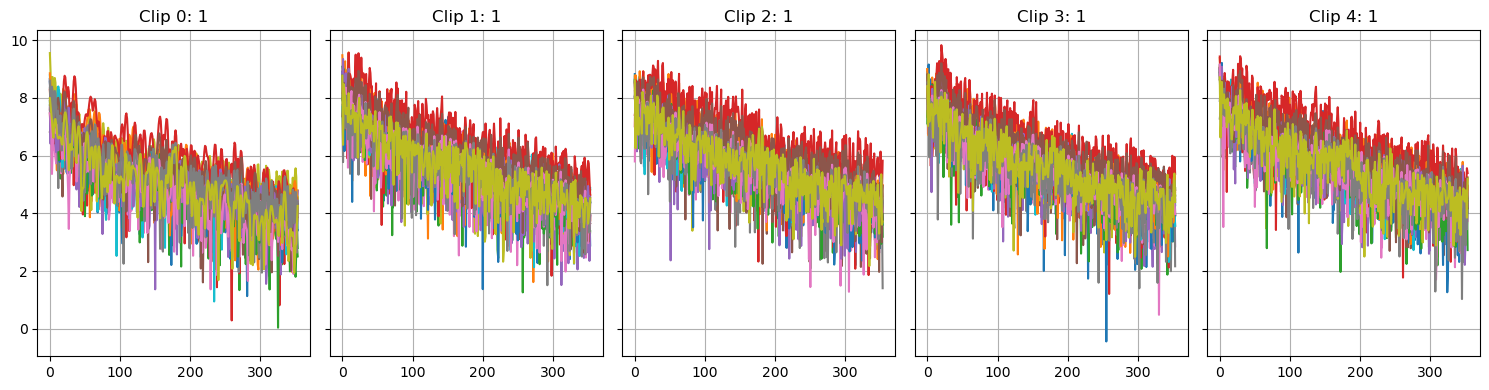

In [10]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i, (x, y) in enumerate(dataset_tr):
    if i > 4:
        break
    axes[i].plot(x)
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {y}"))

fig.tight_layout()
plt.show()

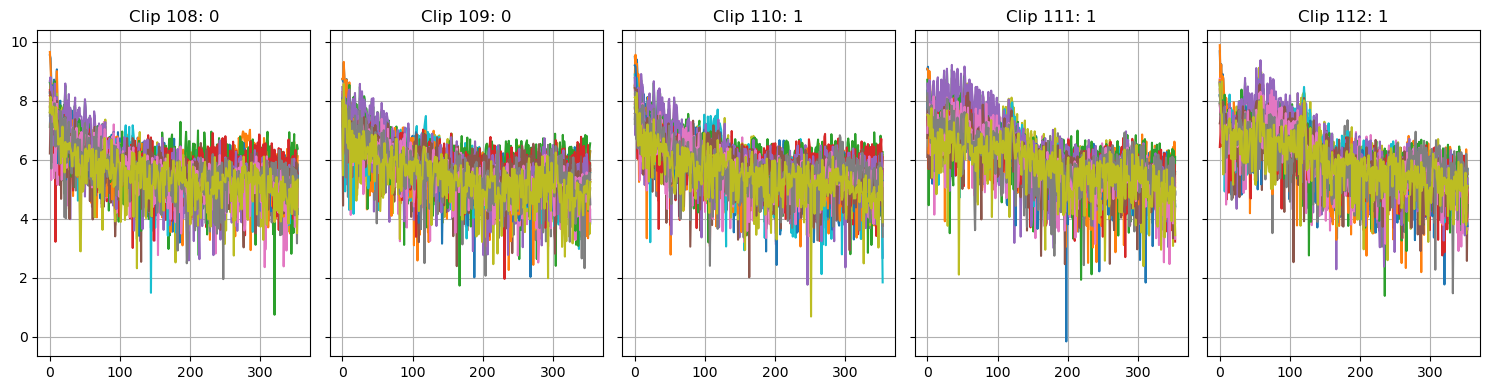

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i, ax in zip(range(108, 113), axes):
    x, y = dataset_tr[i]
    ax.plot(x)
    ax.grid()
    ax.set(title=(f"Clip {i}: {y}"))

fig.tight_layout()
plt.show()

## Compatibility with PyTorch

The `EEGDataset` class is compatible with [pytorch datasets and dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allow you to load batched data.

In [12]:
# Dependences
import os
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm

In [13]:
def seed_everything(seed: int):
    # Python random module
    random.seed(seed)
    # Numpy random module
    np.random.seed(seed)
    # Torch random seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    # Set PYTHONHASHSEED environment variable for hash-based operations
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Ensure deterministic behavior in cudnn (may slow down your training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1)

In [14]:
loader_tr = DataLoader(dataset_tr, batch_size=512, shuffle=True)

In [15]:
for x, y in loader_tr:
    print(x.shape)
    print(y.shape)
    break

torch.Size([512, 354, 19])
torch.Size([512])


## Baseline: LSTM model for sequential data

In this section, we provide a simple baseline for the project using an LSTM model without any special optimization.

In [ ]:
# Define the model
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=19, hidden_dim=64, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, 1)  # Output for binary classification

    def forward(self, x):
        """
        x shape: [batch_size, seq_len, input_dim]
        """
        out, (h_n, c_n) = self.lstm(x)  # out shape: [batch_size, seq_len, hidden_dim]
        last_timestep = out[:, -1, :]  # [batch_size, hidden_dim]
        logits = self.fc(last_timestep)  # [batch_size, 1]
        return logits

In [19]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [20]:
# Instantiate model, loss, and optimizer, then move model to device
model = SimpleLSTM(input_dim=19, hidden_dim=64, num_layers=3, dropout=0.3).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Training loop
num_epochs = 1000
train_losses = []

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in loader_tr:
        # Move data to GPU (if available)
        x_batch = x_batch.float().to(device)  # [batch_size, seq_len, input_dim]
        y_batch = y_batch.float().unsqueeze(1).to(device)  # [batch_size, 1]

        # Forward pass
        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader_tr)
    train_losses.append(avg_loss)

Training: 100%|██████████| 1000/1000 [13:08<00:00,  1.27it/s]


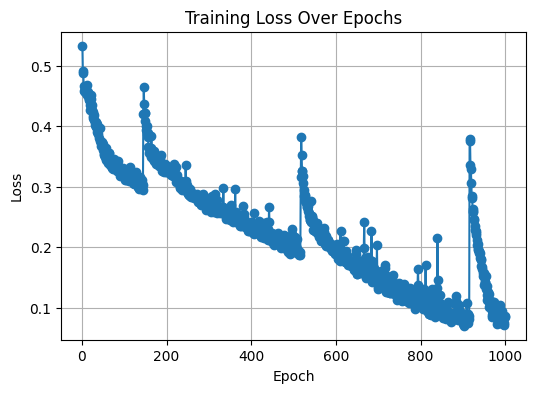

In [ ]:
# Plot the training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_losses, marker="o")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Submission

In [24]:
# Create test dataset
dataset_te = EEGDataset(
    clips_te,  # Your test clips variable
    signals_root=DATA_ROOT
    / "test",  # Update this path if your test signals are stored elsewhere
    signal_transform=fft_filtering,  # You can change or remove the signal_transform as needed
    prefetch=True,  # Set to False if prefetching causes memory issues on your compute environment
    return_id=True,  # Return the id of each sample instead of the label
)

# Create DataLoader for the test dataset
loader_te = DataLoader(dataset_te, batch_size=512, shuffle=False)

In [34]:
# Step 1: Reset the index to get the strings as a column
clips_df = clips_te.reset_index().copy()
# Step 2: Split the 'index' column into multiple columns
split_cols = clips_df['id'].str.split('_', expand=True)
split_cols.columns = ['name', 'session', 'time', 'idx']  # Name them as you want

# Optional: If the last column should be int, cast it
split_cols['idx'] = split_cols['idx'].astype(int)

# Step 3: Drop the old index column
clips_df = clips_df.drop(columns=['id'])

# Step 4: Set the MultiIndex
clips_df.index = pd.MultiIndex.from_frame(split_cols)

print("\nTransformed DataFrame:")
print(clips_df)



Transformed DataFrame:
                         start_time  end_time       date  sampling_rate  \
col1     col2 col3 col4                                                   
pqejgcvm s001 t000 0            0.0      12.0 2002-01-01            250   
                   1           12.0      24.0 2002-01-01            250   
                   2           24.0      36.0 2002-01-01            250   
                   3           36.0      48.0 2002-01-01            250   
                   4           48.0      60.0 2002-01-01            250   
...                             ...       ...        ...            ...   
pqejgvej s001 t000 153       1836.0    1848.0 2015-01-01            250   
                   154       1848.0    1860.0 2015-01-01            250   
                   155       1860.0    1872.0 2015-01-01            250   
                   156       1872.0    1884.0 2015-01-01            250   
                   157       1884.0    1896.0 2015-01-01            250   



In [36]:
"_".join(map(str, clips_df.index[0]))

'pqejgcvm_s001_t000_0'

In [ ]:
# Generate the submission file for Kaggle

# Set the model to evaluation mode
model.eval()

# Lists to store sample IDs and predictions
all_predictions = []
all_ids = []

# Disable gradient computation for inference
with torch.no_grad():
    for batch in loader_te:
        # Assume each batch returns a tuple (x_batch, sample_id)
        # If your dataset does not provide IDs, you can generate them based on the batch index.
        x_batch, x_ids = batch

        # Move the input data to the device (GPU or CPU)
        x_batch = x_batch.float().to(device)

        # Perform the forward pass to get the model's output logits
        logits = model(x_batch)

        # Convert logits to predictions.
        # For binary classification, threshold logits at 0 (adjust this if you use softmax or multi-class).
        predictions = (logits > 0).int().cpu().numpy()

        # Append predictions and corresponding IDs to the lists
        all_predictions.extend(predictions.flatten().tolist())
        all_ids.extend(list(x_ids))

# Create a DataFrame for Kaggle submission with the required format: "id,label"
submission_df = pd.DataFrame({"id": all_ids, "label": all_predictions})

# Save the DataFrame to a CSV file without an index
submission_df.to_csv("submission_seed1.csv", index=False)
print("Kaggle submission file generated: submission.csv")

Kaggle submission file generated: submission.csv
